# THE WAR AGAINST HEART ARRHYTHMIA

In [1]:
import numpy as np
from scipy.optimize import fsolve
import math
import pywt
import cython
import pandas as pd
import scipy.signal
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from statsmodels.tsa.stattools import acf
import random
from collections import deque
import statsmodels.graphics.tsaplots as st
from scipy import special
from scipy.signal import find_peaks
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy import integrate
import pyspeckit
from pyspeckit import moments
import arch
from arch.unitroot import VarianceRatio

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Signal preprocessing:

1. Subtract the mean
2. Five order moving average filtering
3. High Pass Filtering with f = 1 Hz (Drift Suppression)
4. low-pass Butterworth filtering with fc = 30 Hz

In [2]:
def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data


def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    s,t= signal_preprocessor(s,t,freq1,30)
    return s,t

def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = t[index_M[0][0]:-1]
    return signal_start,time_M

def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

## Signals and Times arrays:

In [3]:
signals = []
times = []
str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)

In [4]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)

In [5]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [6]:
def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

In [7]:
ss,tt = for_sigmar(signals,times)

In [8]:
sm,tm = start_end_ext(ss,tt)

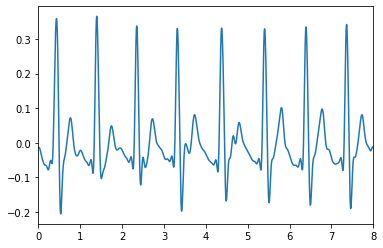

In [9]:
plt.xlim((0, 8))
#plt.ylim((930,1050))
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400])

In [10]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

In [11]:
for i in range(len(ss)):
    print("Signal number: ",i+1,"Number of signals: ",len(ss[i]))

Signal number:  1 Number of signals:  196
Signal number:  2 Number of signals:  196
Signal number:  3 Number of signals:  196
Signal number:  4 Number of signals:  196
Signal number:  5 Number of signals:  196
Signal number:  6 Number of signals:  196
Signal number:  7 Number of signals:  196
Signal number:  8 Number of signals:  196
Signal number:  9 Number of signals:  196
Signal number:  10 Number of signals:  196
Signal number:  11 Number of signals:  196
Signal number:  12 Number of signals:  196
Signal number:  13 Number of signals:  196
Signal number:  14 Number of signals:  196
Signal number:  15 Number of signals:  196
Signal number:  16 Number of signals:  196
Signal number:  17 Number of signals:  196
Signal number:  18 Number of signals:  196
Signal number:  19 Number of signals:  196
Signal number:  20 Number of signals:  196
Signal number:  21 Number of signals:  196
Signal number:  22 Number of signals:  196
Signal number:  23 Number of signals:  196
Signal number:  24 N

In [12]:
def annotation_symbols(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.aux_note)
    return np.array(ann_list)

def annotation_locations(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.sample)
    return np.array(ann_list)

In [13]:
ann_list =[]
ann_locations = []

str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]

for i in MIT_str:
    ann_list.append(annotation_symbols(str1,i))
    ann_locations.append(annotation_locations(str1,i))

In [14]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]

for i in cudb_str:
    ann_list.append(annotation_symbols(str2,i))
    ann_locations.append(annotation_locations(str2,i))

In [15]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]

for i in vfdb_str:
    ann_list.append(annotation_symbols(str3,i))
    ann_locations.append(annotation_locations(str3,i))

In [16]:
ann_list=np.array(ann_list)
ann_locations = np.array(ann_locations)

In [17]:
ann_list

array([array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['', '(N', '', ..., '', '', ''], dtype='<U4'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U2'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U6'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '',

In [18]:
ann_locations

array([array([    18,     77,    370, ..., 649484, 649734, 649991]),
       array([     7,     83,    396, ..., 649004, 649372, 649751]),
       array([    68,    136,    410, ..., 649244, 649553, 649852]),
       array([    21,    265,    575, ..., 649195, 649534, 649875]),
       array([    36,     73,    316, ..., 649300, 649580, 649876]),
       array([    67,    197,    459, ..., 649221, 649471, 649740]),
       array([    83,    229,    351, ..., 649162, 649340, 649791]),
       array([    47,     95,    272, ..., 649129, 649441, 649748]),
       array([    23,     88,    442, ..., 649170, 649471, 649769]),
       array([    18,    111,    343, ..., 649378, 649663, 649931]),
       array([    31,    197,    489, ..., 649148, 649441, 649724]),
       array([    15,    124,    382, ..., 649361, 649626, 649883]),
       array([    22,    170,    583, ..., 649364, 649675, 649994]),
       array([    21,    310,    726, ..., 649261, 649523, 649783]),
       array([    44,    161,    5

In [19]:
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [20]:
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [173]:
def fib_location(lis,loc):
    listlist = []
    listmist = []
    for i in range(len(lis)):
        for j in range(len(lis[i])):
            if lis[i][j]== '(VF' or lis[i][j] == '(VT' or lis[i][j] == '(VFL' or lis[i][j] == '(VF' or lis[i][j] == '(SVTA':
                for k in range(len(ann_list[i][j+1:-1])):
                    if ann_list[i][j+k+1] != '':
                        lastone = loc[i][j+k]
                        duration = lastone - loc[i][j-1]
                        break
                if i <=47:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Duration: ",duration/300,"s"," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", ((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])),"until: ",((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append(((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append(((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                elif 47 < i < 83: 
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                elif i >= 83:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
    return np.array(listlist),np.array(listmist)

In [179]:
VFVT_labels = [0.0]*14236
VFVT_labels = np.array(VFVT_labels)
Y_loc= fib_location(ann_list,ann_locations)

Signal number:  7  Type:  (VT  Location:  63624  Duration:  1.7866666666666666 s  Location in Signal division =  19  Location in vertical labels =  1195 until:  1195
Signal number:  14  Type:  (SVTA  Location:  251900  Duration:  5.233333333333333 s  Location in Signal division =  75  Location in vertical labels =  2623 until:  2624
Signal number:  24  Type:  (VT  Location:  39210  Duration:  2.2066666666666666 s  Location in Signal division =  11  Location in vertical labels =  4519 until:  4519
Signal number:  24  Type:  (VT  Location:  226766  Duration:  1.7166666666666666 s  Location in Signal division =  68  Location in vertical labels =  4576 until:  4576
Signal number:  24  Type:  (VT  Location:  340338  Duration:  3.0 s  Location in Signal division =  102  Location in vertical labels =  4610 until:  4610
Signal number:  24  Type:  (VT  Location:  385419  Duration:  1.9133333333333333 s  Location in Signal division =  116  Location in vertical labels =  4624 until:  4624
Signal 

Signal number:  40  Type:  (VT  Location:  282509  Duration:  1.77 s  Location in Signal division =  85  Location in vertical labels =  7729 until:  7729
Signal number:  40  Type:  (VT  Location:  303035  Duration:  1.6633333333333333 s  Location in Signal division =  91  Location in vertical labels =  7735 until:  7735
Signal number:  41  Type:  (SVTA  Location:  257703  Duration:  1.7833333333333334 s  Location in Signal division =  77  Location in vertical labels =  7917 until:  7917
Signal number:  41  Type:  (SVTA  Location:  466208  Duration:  2.03 s  Location in Signal division =  140  Location in vertical labels =  7980 until:  7980
Signal number:  41  Type:  (SVTA  Location:  469227  Duration:  2.466666666666667 s  Location in Signal division =  141  Location in vertical labels =  7981 until:  7981
Signal number:  41  Type:  (SVTA  Location:  476344  Duration:  3.52 s  Location in Signal division =  143  Location in vertical labels =  7983 until:  7983
Signal number:  42  Type

Signal number:  85  Type:  (VFL  Location:  229923  Location in Signal division =  69  Location in vertical labels =  10891 until:  10891
Signal number:  85  Type:  (VFL  Location:  345211  Location in Signal division =  104  Location in vertical labels =  10926 until:  10926
Signal number:  85  Type:  (VFL  Location:  423830  Location in Signal division =  128  Location in vertical labels =  10950 until:  10950
Signal number:  85  Type:  (VFL  Location:  487737  Location in Signal division =  147  Location in vertical labels =  10969 until:  10969
Signal number:  85  Type:  (VFL  Location:  492596  Location in Signal division =  149  Location in vertical labels =  10971 until:  10971
Signal number:  86  Type:  (VT  Location:  357538  Location in Signal division =  108  Location in vertical labels =  11089 until:  11089
Signal number:  86  Type:  (VT  Location:  398673  Location in Signal division =  120  Location in vertical labels =  11101 until:  11101
Signal number:  86  Type:  (VT

In [228]:
i = 0
counter = 0
while 3 > 2:
    for l in range(Y_loc[0][i],Y_loc[1][i]+1):
        VFVT_labels[l] = 1.0
        counter+=1
    i+=1
    if i == 305:
        break

In [229]:
VFVT_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [230]:
lismis = []
for i in range(len(VFVT_labels)):
    if VFVT_labels[i] == 1: 
        lismis.append(i)

In [231]:
len(lismis)

283

In [242]:
counter = 0
for i in lismis:
    if ACF_test(sm[i][0:2400]) <=6.61:
        counter +=1  

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid 

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned param


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The len

QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during lear


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initi


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during lear


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned param


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Fo


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater_equal

The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



In [243]:
counter

233

# Time parameter

In [40]:
t_cst = len(ss[0][0])/tt[0][0][-1]
t_cst  ##number of signal points in 1 second

300.09047044632086

## Parameter 1: TCI

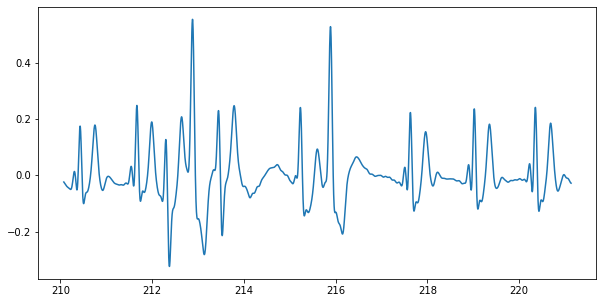

In [41]:
ss[6][19].size
tt[6][19].size
plt.figure(figsize=(10,5))
plt.plot(tt[6][19],ss[6][19])

In [42]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

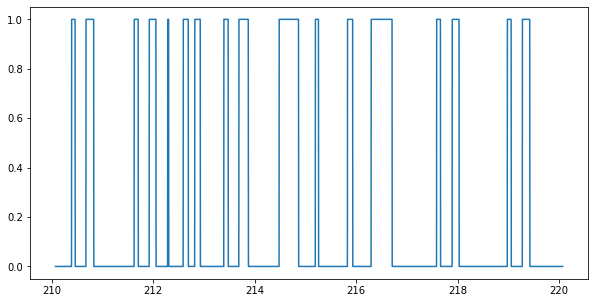

In [43]:
binlist,thd = binary_td(ss[6][19],0,10)
plt.figure(figsize=(10,5))
plt.plot(tt[6][19][0:10*300],binlist)
binlist[300:2700]

In [44]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        if t1+t2 == 0:
            TCI.append(0)
        elif t3+t4==0:
            TCI.append(0)
        else:
            form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
            if form1 == 0:
                TCI.append(0)
            else:
                form2=1000/form1
                TCI.append(form2)
            q+=300
            p+=300
            k+=1
    return np.array(TCI)

In [45]:
binlist,thd = binary_td(ss[6][19],0,10)
TCI(binlist,thd,1,9)

array([562.62558607, 309.73451327, 496.62712259, 767.97179907,
       567.88848735, 974.88921713, 612.63834345, 960.98294885])

## TCI Extraction:

In [62]:
def TCI_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            binlist,thd = binary_td(ss[i][j],0,10)
            values.append(TCI(binlist,thd,1,9))
    return np.array(values)

In [64]:
TCI = TCI_ext(ss)

In [65]:
TCI[0]

array([ 985.71428571,  951.04646136,  950.16888638,  941.09609647,
        974.68877589,  866.32910041, 1670.37989146,  795.03305918])

In [66]:
l = []
for i in TCI:
     l.append([pd.DataFrame({ i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7] })])
ll = []
for i in l:
    ll.append(pd.DataFrame(i))
TCI_DF = pd.concat(ll)
TCI_DF.columns = ["TCI"]

In [67]:
TCI_DF

TCI
0                0
0   866.329100
1  1670.379891
2...
0                0
0   954.516496
1   961.907372
2...
0                0
0   932.685362
1  1002.087758
2...
0                0
0   993.735132
1   961.845837
2...
0                0
0  1121.418827
1   962.612343
2...
0                0
0   993.598333
1  1001.035468
2...
0                0
0   965.953556
1  1160.825732
2...
0                0
0   961.191943
1   963.171929
2...
0               0
0  963.378322
1  996.601571
2  9...
0                0
0  1025.644765
1  1025.057499
2...
0               0
0  993.357952
1  966.828001
2  9...
0                0
0   965.153155
1   997.802525
2...
0                0
0   933.915563
1   968.459972
2...
0                0
0   935.168727
1   967.994488
2...
0                0
0   928.514966
1  1249.908970
2...
0               0
0  970.794003
1  939.254928
2  9...
0               0
0  930.555556
1  968.285679
2  9...
0                0
0   867.768595
1   937.573661
2...
0                0
0   992.058007
1   994.322811
2...
0               0
0  993.530647
1  934.486041
2  9...
0                0
0   994.494562
1   972.378637
2...
0                0
0   999.051746
1   938.364327
2...
0                0
0  1218.664227
1  1000.416468
2...
0               0
0  934.732424
1  968.406593
2  9...
0                0
0   964.924416
1   933.107126
2...
0                0
0  1030.873982
1  1002.867163
2...
0                0
0   964.037123
1  1002.698730
2...
0                0
0   998.144803
1   999.853805
2...
0                0
0   962.503341
1  1026.310067
2...
0                0
0   993.445762
1   996.762309
2...
..                                                ...
0                0
0  1696.452086
1  1536.054638
2...
0                0
0  1186.666667
1  1477.222237
2...
0                0
0  1056.396181
1  1217.074407
2...
0                0
0   705.956100
1   880.589317
2...
0                0
0  1636.666667
1  1573.003985
2...
0                0
0   802.415992
1  1513.333333
2...
0                0
0  1313.048566
1  1286.852590
2...
0                0
0  1218.789002
1  5410.000000
2...
0                0
0  1358.937527
1  1072.572858
2...
0                0
0   930.822679
1  1319.454032
2...
0                  0
0   10661.409681
1  282727.27...
0                0
0  1540.036214
1  1226.851216
2...
0                0
0  1128.648429
1   -20.503962
2...
0                0
0  1249.785730
1   866.200854
2...
0                0
0  1090.000000
1   866.425993
2...
0                0
0     0.000000
1  1450.760170
2...
0                0
0   -30.000000
1   -24.059302
2...
0                0
0   -64.657699
1  -254.389547
2...
0                0
0  -252.472368
1  1573.333333
2...
0                0
0   928.071068
1   805.227705
2...
0                0
0   961.670843
1   836.839560
2...
0                0
0  1666.831664
1   936.772663
2...
0                 0
0   2663.333333
1    749.51152...
0                0
0   608.127576
1   992.981932
2...
0                0
0  1576.666667
1  1689.314621
2...
0                0
0  1443.096345
1  1255.948005
2...
0                0
0  1185.770751
1   835.093012
2...
0                0
0  1568.156504
1  1669.477234
2...
0                0
0   -91.334895
1  5287.937743
2...
0                0
0  1506.666667
1  1091.539787
2...

[14236 rows x 1 columns]

# Parameter 2: ACF Algorithm

In [50]:
qrs_inds = processing.xqrs_detect(sig=ss[2][0][0:2400], fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

44

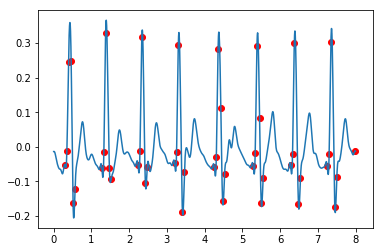

In [52]:
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400])
plt.scatter(tt[2][0][qrs_inds],ss[2][0][qrs_inds],color="red")
x = int(len(qrs_inds))
x

In [57]:
ser = acf(ss[2][0][0:2400],nlags=x,alpha=0.01)

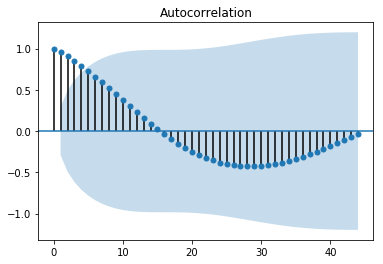

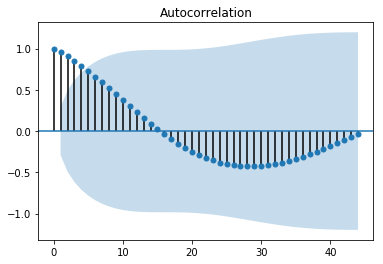

In [58]:
st.plot_acf(ser[0])

In [59]:
vr = VarianceRatio(ser[0])
vr.overlap=False
vr.stat

4.641282036531771

In [218]:
def ACF_test(signal):
    qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
    x = int(len(qrs_inds))
    ser = acf(signal,nlags=x,alpha=0.05)
    vr = VarianceRatio(ser[0])
    vr.overlap=False
    return vr.stat

In [219]:
ACF_test(ss[2][0][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


4.641282036492195

## ACF Extraction:

In [63]:
def ACF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ACF_test(ss[i][j][0:2400]))
    return np.array(values)

In [ ]:
#ACF = ACF_ext(ss)

In [ ]:
ACF

In [ ]:
ACF_DF = pd.DataFrame(ACF)
ACF_DF.columns = ["ACF"]

In [ ]:
ACF_DF

## Parameter 3: VF Filter

In [64]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def VF_Filter_leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [65]:
VF_Filter_leakage(ss[2][0][0:2400],int(get_points(ss[2][0][0:2400],300)),200,500)

0.634487213285533

## VF Filter Extraction

In [ ]:
def VFF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(VF_Filter_leakage(ss[i][j][0:2400],int(get_points(ss[i][j][0:2400],300)),200,500))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["VFF"]
    return v

In [ ]:
VFF_DF = VFF_ext(ss)

## Parameter 4: Spectral Algorithm

In [29]:
Ham = MIT_signal[0:2400]*np.hamming(2400)

(-120, 120)

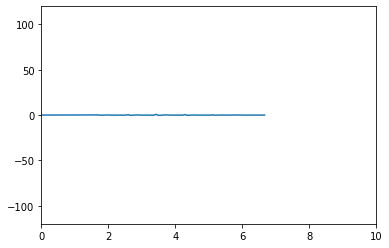

In [30]:
plt.plot(time[0:2400],Ham)
plt.xlim(0,10)
plt.ylim(-120,120)

In [31]:
fourier = scipy.fft(Ham)

In [32]:
fourier

array([-0.22628347+0.j        , -0.22701253+0.02394437j,
       -0.23126225+0.04699765j, ..., -0.22889275-0.10295006j,
       -0.23126225-0.04699765j, -0.22701253-0.02394437j])

Casting complex values to real discards the imaginary part


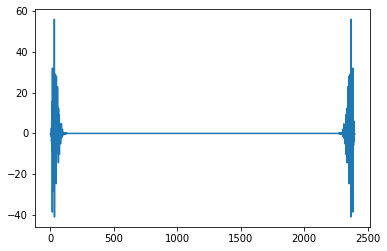

In [33]:
plt.plot(fourier)

In [34]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [35]:
fourier_2 = fourier_abs(fourier).real

In [36]:
fourier_2

array([0.22628347, 0.2509569 , 0.2782599 , ..., 0.33184282, 0.2782599 ,
       0.2509569 ])

(0, 10)

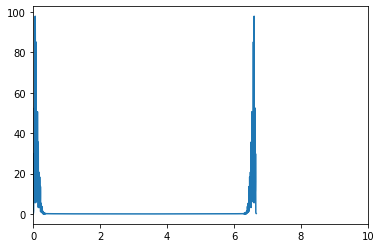

In [37]:
plt.plot(time[0:2400],fourier_2)
plt.xlim(0,10)

In [38]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [39]:
time_2

2.0

In [40]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

13
50.614812928583326


In [41]:
f.index(m)

13

In [42]:
f[6]

25.378390237140998

In [43]:
time_max_amp = f.index(m)/300 ## in seconds
if time_max_amp != 0:
    God_of_War = 1/time_max_amp
else:
    God_of_War = 0
God_of_War

23.076923076923077

In [44]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [45]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0., 0., 0., ..., 0., 0., 0.])

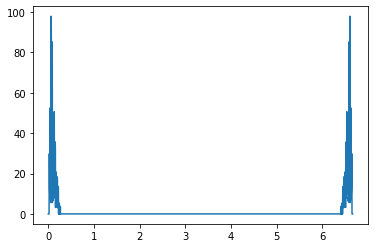

In [46]:
plt.plot(time[0:2400],fourier_final)

In [47]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


<Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at -0x7fffffe57d57ef1c>

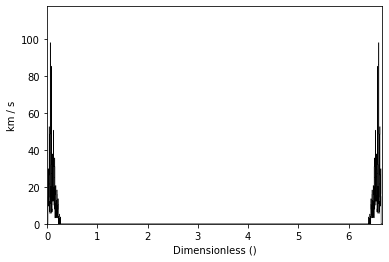

In [48]:
pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],doplot="True",unit ='km / s' )

In [49]:
Mk = pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],unit = 'km / s').moments
Mk

<bound method BaseSpectrum.moments of <Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at 0x1a82a82b86>>

In [50]:
np.minimum(1,2)

1

In [51]:
sum(MIT_signal[0:2400])

-2.938399091551117

In [52]:
def A_calc(f1,f2,f3,f4,signal):
    i1 = int((f1)*300)
    i2 = int((f2)*300)
    i3 = int((f3)*300)
    i4 = int((f4)*300)
    
    if i1<i2:
        A=0
        for i in range(len(signal[i1:i2])):
            A += signal[i]
    else:
        A=0
        for i in range(len(signal[i2:i1])):
            A += signal[i]
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])

    return (A/B)

In [53]:
A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
A1

1.0000000000000007

In [54]:
A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),MIT_signal[0:2400])
A2

-0.0

In [55]:
A = np.arange(2*God_of_War,8*God_of_War,0.6)
A = ((1/A)*t_cst).astype(int)
A = np.unique(A)
A

array([1, 2, 3, 4, 5, 6, 7])

In [56]:
def A3_calc(signal,God_of_War):
    A = np.arange(2*God_of_War,8*God_of_War,0.6)
    A = ((1/A)*t_cst).astype(int)
    A = np.unique(A)
    A = sum(signal[A])
    
    i3 = int((1/0.5)*300)
    i4 = int(1/np.minimum(20*God_of_War,100))
    
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return A/B

In [57]:
A3_calc(MIT_signal[0:2400],God_of_War)

-1.0240904109272688

In [58]:
def SPEC(signal):
    Ham = signal*np.hamming(2400)
    fourier = scipy.fft(Ham)
    fourier_2 = fourier_abs(fourier).real
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = fourier_2[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    fourier_final = amp_maxsetter(fourier_2,m)
    
    A3 = A3_calc(fourier_2,God_of_War)
    
    return A3

In [59]:
SPEC(MIT_signal[0:2400])

0.009584663943600327

## Spectral Extraction:

In [ ]:
def SPEC_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SPEC(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SPEC"]
    return v

In [ ]:
SPEC_DF = SPEC_ext(ss)

## Parameter 5: Complexity Measure Algorithm

In [67]:
nurgle = ss[2][0][0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

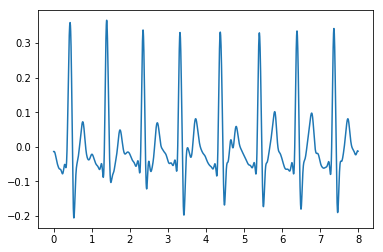

In [69]:
plt.plot(tt[2][0][0:2400],nurgle)

In [70]:
def Td(nurgle):
    meanbean = np.mean(nurgle)
    nurgle = nurgle - meanbean
    Vp = np.amax(nurgle)
    Vn = np.amin(nurgle)
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [71]:
Threshold = Td(nurgle)
Threshold

0

In [72]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [73]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary,length):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    bn = length/(math.log2(length))
    
    return cn/bn

In [75]:
def complexity_measure(nurgle,length):
    Threshold = Td(nurgle)
    binary = binary_comp(Threshold,nurgle)
    return complexity(binary,length)

In [76]:
def comp_measure(signal,length):
    l = 0
    k = 0
    j = 300
    for i in range(0,8):
        l += complexity_measure(signal[k:j],length)
        k+=300
        j+=300
    return l

In [ ]:
complexity_measure(ss[2][2][0:2400],2400) ## use an AWS for this

## Complexity Measure Extraction:

In [ ]:
def Comp_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(comp_measure(ss[i][j][0:2400],2400))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Complexity"]
    return v

In [ ]:
Comp_DF = Comp_ext(ss)

## Parameter 6: Standard Exponential Algorithm

In [200]:
def std_exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    #plt.figure(figsize=(20,10))
    #plt.plot(t,signal)
    #plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    #plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

In [201]:
std_exp_algthm(tt[2][0][0:2400],ss[2][0][0:2400],3)

165.0

In [87]:
time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [88]:
tt[0][0]

array([0.00000000e+00, 3.33333333e-03, 6.66666667e-03, ...,
       1.10466667e+01, 1.10500000e+01, 1.10533333e+01])

## Standard Exponential Extraction:

In [89]:
def stdexp_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(std_exp_algthm(tt[i][j][0:2400],ss[i][j][0:2400],3))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["ST_EXP"]
    return v

In [ ]:
ST_EXP_DF = stdexp_ext(ss,tt) 

In [ ]:
ss[0][0][0:2400]

## Parameter 7: Modified Exponential Algorithm

In [220]:
### Note that the function only works by the book if the starting point is a maximum

def MEA(t,signal,Tau):
    real_curve = [0.0]*len(t)
    index_M  = argrelextrema(signal,np.greater)
    idx_M = index_M[0]
    gladiator = np.amax(signal)
    idx_M2 = []
    for i in idx_M:
        if signal[i]>0.2*gladiator:
            idx_M2.append(i)
    idx_M2 = np.array(idx_M2)
    idx_M1 = []
    for i in idx_M:
        if signal[i]>0.1*gladiator:
            idx_M1.append(i)
    idx_M1 = np.array(idx_M1)
    
    ## draw the first curve
    pt = 0
    qqq = 0
    lifts=0
    while 2 < 3: 
        if pt >= idx_M[-1]: 
            break
        M1 = signal[pt]
        tm1 = t[pt]
        curve_1 = M1*np.exp(-1*(t-tm1)/(Tau))
        idx_1 = np.argwhere(np.diff(np.sign(signal-curve_1))).flatten()
        for i in idx_1:
            if i > 11+pt:
                idx_work = i
                break
        ## find all the maxes 
        for j in range(len(idx_M)):
            if idx_work <= idx_M[j]:
                idx_M_work = idx_M[j]
                break
        real_curve[pt:idx_work] = (curve_1[pt:idx_work])
        real_curve[idx_work:idx_M_work]=(signal[idx_work:idx_M_work])
        pt = idx_M_work
        if pt ==qqq:
            break
        qqq = idx_M_work
        lifts+=1
        if pt >= idx_M[-1]:     ### Also note that the main problem with the algorithm is that I don't know what I should set as a condition to end the function yet
            break
    idx_final = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    #plt.figure(figsize=(20,10))
    #plt.plot(t,signal,color="blue")
    #plt.plot(t,real_curve,color="green")
    #plt.plot(t[idx_final],signal[idx_final],'ro')
    pt=idx_M_work
    Time_length = t[pt]-t[0]
    form = lifts/Time_length
    return form*60

In [221]:
MEA(tm[1195][0:2400],sm[1195][0:2400],0.2)

141.60111059694614

## Modified Exponential Extraction:

In [108]:
def MEA_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(MEA(tt[i][0:-1],ss[i][0:-1],0.2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MDF_EXP"]
    return v

In [109]:
MEA_DF = MEA_ext(sm,tm)

NameError: name 'MEA' is not defined

In [110]:
MEA_DF

NameError: name 'MEA_DF' is not defined

## Parameter 8: Signal Comparison

In [92]:
signal = MIT_signal[0:2400]
signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
time_1 = time[0:2400]
qrs_inds = processing.xqrs_detect(sig=signal, fs=41)

NameError: name 'MIT_signal' is not defined

In [93]:
wfdb.plot_items(signal=signal, ann_samp=[qrs_inds])
qrs_inds

NameError: name 'signal' is not defined

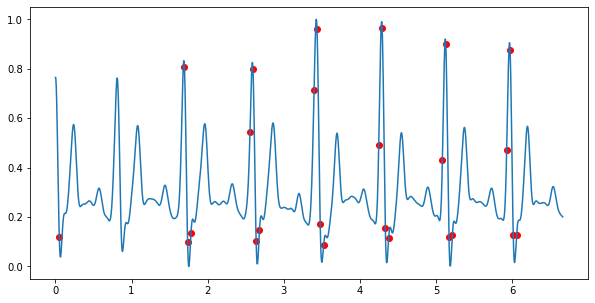

In [205]:
plt.figure(figsize=(10,5))
plt.plot(time_1,signal)
plt.scatter(time_1[qrs_inds],signal[qrs_inds],color="red")

Let's create the first signal:

In [206]:
MIT_signal_1 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/102")

MIT_data_1 = signal_creator(MIT_signal_1)

fs = 360
time = np.arange(MIT_data_1.size)/fs
MIT_signal_1,time_2 = signal_preprocessor(MIT_data_1,time,360,30)
MIT_signal_1 = wfdb.processing.normalize_bound(MIT_signal_1, lb=0, ub=1)
MIT_signal_1,time_2

(array([0.53113576, 0.53121544, 0.53126273, ..., 0.55778183, 0.55704352,
        0.55644496]),
 array([0.00000000e+00, 3.33333333e-03, 6.66666667e-03, ...,
        2.16665667e+03, 2.16666000e+03, 2.16666333e+03]))

Adjust the peaks to match the QRS points found for the signal we want to examine:

In [258]:
SCA_1 = MIT_signal_1[0:2400]
qrs_inds_2 = processing.xqrs_detect(sig=SCA_1, fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


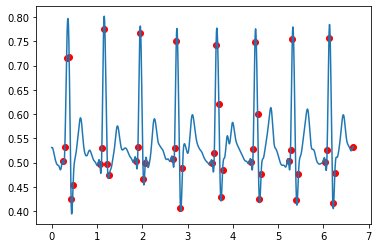

In [259]:
plt.plot(time_1,SCA_1)
plt.scatter(time_1[qrs_inds_2],SCA_1[qrs_inds_2],color = "red")

Now to create the second signal:

In [209]:
fs=360
s1 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/101")
s1 = signal_creator(s1)
t1 = np.arange(s1.size)/fs
s1,t1= signal_preprocessor(s1,t1,360,30)
#s1 = wfdb.processing.normalize_bound(s1, lb=-1, ub=1)

s2 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/103")
s2 = signal_creator(s2)
t2 = np.arange(s2.size)/fs
s2,t2= signal_preprocessor(s2,t2,360,30)
#s2 = wfdb.processing.normalize_bound(s2, lb=-1, ub=1)

s3 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/105")
s3 = signal_creator(s3)
t3 = np.arange(s3.size)/fs
s3,t3= signal_preprocessor(s3,t3,360,30)
#s3 = wfdb.processing.normalize_bound(s3, lb=-1, ub=1)

s4 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/106")
s4 = signal_creator(s4)
t4 = np.arange(s4.size)/fs
s4,t4= signal_preprocessor(s4,t4,360,30)
#s4 = wfdb.processing.normalize_bound(s4, lb=-1, ub=1)

s5 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/108")
s5 = signal_creator(s5)
t5 = np.arange(s5.size)/fs
s5,t5= signal_preprocessor(s5,t5,360,30)
#s5 = wfdb.processing.normalize_bound(s5, lb=-1, ub=1)

s6 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/109")
s6 = signal_creator(s6)
t6 = np.arange(s6.size)/fs
s6,t6= signal_preprocessor(s6,t6,360,30)
#s6 = wfdb.processing.normalize_bound(s6, lb=-1, ub=1)

s7 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/111")
s7 = signal_creator(s7)
t7 = np.arange(s7.size)/fs
s7,t7= signal_preprocessor(s7,t7,360,30)
#s7 = wfdb.processing.normalize_bound(s7, lb=-1, ub=1)

s8 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/112")
s8 = signal_creator(s8)
t8 = np.arange(s8.size)/fs
s8,t8= signal_preprocessor(s8,t8,360,30)
#s8 = wfdb.processing.normalize_bound(s8, lb=-1, ub=1)

s9 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/113")
s9 = signal_creator(s9)
t9 = np.arange(s9.size)/fs
s9,t9= signal_preprocessor(s9,t9,360,30)
#s9 = wfdb.processing.normalize_bound(s9, lb=-1, ub=1)

s10 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/114")
s10 = signal_creator(s10)
t10 = np.arange(s10.size)/fs
s10,t10= signal_preprocessor(s10,t10,360,30)
#s10 = wfdb.processing.normalize_bound(s10, lb=-1, ub=1)

s11 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/115")
s11 = signal_creator(s11)
t11 = np.arange(s11.size)/fs
s11,t11= signal_preprocessor(s11,t11,360,30)
#s11 = wfdb.processing.normalize_bound(s11, lb=-1, ub=1)

s12 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/116")
s12 = signal_creator(s12)
t12 = np.arange(s12.size)/fs
s12,t12= signal_preprocessor(s12,t12,360,30)
#s12 = wfdb.processing.normalize_bound(s12, lb=-1, ub=1)

s13 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/117")
s13 = signal_creator(s13)
t13 = np.arange(s13.size)/fs
s13,t13= signal_preprocessor(s13,t13,360,30)
#s13 = wfdb.processing.normalize_bound(s13, lb=-1, ub=1)

s14 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/118")
s14 = signal_creator(s14)
t14 = np.arange(s14.size)/fs
s14,t14= signal_preprocessor(s14,t14,360,30)
#s14 = wfdb.processing.normalize_bound(s14, lb=-1, ub=1)

s15 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/119")
s15 = signal_creator(s15)
t15 = np.arange(s15.size)/fs
s15,t15= signal_preprocessor(s15,t15,360,30)
#s15 = wfdb.processing.normalize_bound(s15, lb=-1, ub=1)

s16 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/121")
s16 = signal_creator(s16)
t16 = np.arange(s16.size)/fs
s16,t16= signal_preprocessor(s16,t16,360,30)
#s16 = wfdb.processing.normalize_bound(s16, lb=-1, ub=1)

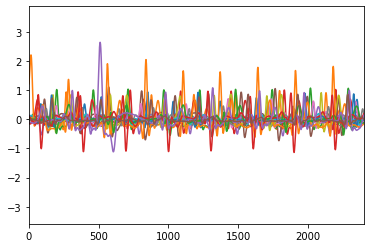

In [210]:
plt.xlim(0,2400)
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)
plt.plot(s4)
plt.plot(s5)
plt.plot(s6)
plt.plot(s7)
plt.plot(s8)
plt.plot(s9)
plt.plot(s10)
plt.plot(s11)
plt.plot(s12)
plt.plot(s13)
plt.plot(s14)
plt.plot(s15)
plt.plot(s16)

In [211]:
def signal_size_adjustor(signal):
    k = len(signal)-1
    m = np.mean(signal)
    signal = signal.tolist()
    while k < 650000:
        signal.append(m)
        k+=1
    time = np.arange(np.array(signal).size)/300
    return np.array(signal),time

In [212]:
def starting_point_2(signal,t):
    M = np.amax(signal[8:500])
    ss = signal.tolist()
    index_M = ss.index(M)
    signal_start = signal[index_M:-1]
    fs=300
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

In [213]:
sig_array = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16]
time_array = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]
sig_1 = []
sig_2 = []
for i in range(0,16):
    x,y = starting_point_2(sig_array[i],time_array[i])
    sig_1.append(x)
    sig_2.append(y)

In [214]:
ss = s1
M = np.amax(s1[8:500])
sss = ss.tolist()
sss.index(M)

85

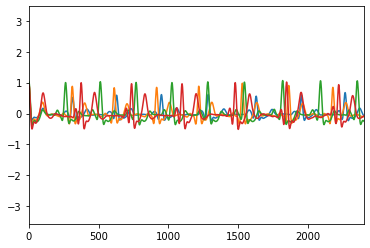

In [215]:
plt.xlim(0,2400)
plt.plot(sig_1[0])
plt.plot(sig_1[1])
plt.plot(sig_1[2])
plt.plot(sig_1[3])

In [216]:
sig_3 = []
sig_4 = []
for i in range(0,16):
    x,y = signal_size_adjustor(sig_1[i])
    sig_3.append(x)
    sig_4.append(y)

In [217]:
avg = []
for i in range(0,650001):
    avg.append(0)
avg = np.array(avg)
for i in sig_3:
    avg = avg + i
avg = avg/len(sig_3)

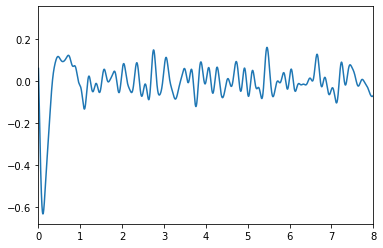

In [218]:
SCA_2 = avg
SCA_2,t1= signal_preprocessor(SCA_2,sig_4[0],360,50)
plt.xlim(0,8)
plt.plot(t1,SCA_2)

In [221]:
#plt.plot(t1, sig_2)
#plt.xlim(0,10)

Now for the third signal, it just has an elevated T wave:

In [224]:
SCA_3 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/107")
SCA_3 = signal_creator(SCA_3)
time_third = np.arange(SCA_3.size)/fs
SCA_3,time_third= signal_preprocessor(SCA_3,time_third,360,30)

For the fourth signal:

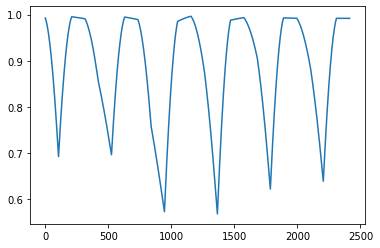

In [225]:
x = []
spacing1 = len(signal)/(len(qrs_inds)-1)
for i in range(len(signal[qrs_inds])-1):
    spacing2 = (signal[qrs_inds[i+1]] - signal[qrs_inds[i]])/spacing1
    y = np.arange(signal[qrs_inds[i]],signal[qrs_inds[i+1]],spacing2) ##Needs to be a formula
    for i in y:
        x.append(i)
x = np.array(x)
SCA_4 = np.cos(x)
plt.plot(SCA_4)
len(SCA_4)
SCA_4 = np.resize(SCA_4,(2400,))

Now for the residual calculation

In [226]:
I0 = qrs_inds[0]
I1 = qrs_inds[-1]

In [227]:
def Integral_calc(S,F,I0,I1):
    y = np.absolute(S-F)
    R = integrate.simps(y[I0:I1])
    return R

In [228]:
RF   = Integral_calc(signal,SCA_4,I0,I1)
RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
print("RF = ",RF)
print("RFS1 = ",RFS1)
print("RFS2 = ",RFS2)
print("RFS3 = ",RFS3)

RF =  1258.61377751472
RFS1 =  596.418401358999
RFS2 =  682.4729631665994
RFS3 =  1422.5166305200044


In [229]:
IF  = Integral_calc(SCA_4,0,I0,I1)
IE  = Integral_calc(signal,0,I0,I1)
IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)

print("IF = ",IF)
print("IE = ",IE)
print("IS1 = ",IS1)
print("IS2 = ",IS2)
print("IS3 = ",IS3)

IF =  1910.9132592657952
IE =  660.1794239367207
IS1 =  1166.532893296359
IS2 =  128.26320006865893
IS3 =  1290.833345292845


In [230]:
VRF = (RF/min(IF,IE))
VRS1 = RFS1/min(IS1,IE)
VRS2 = RFS2/min(IS2,IE)
VRS3 = RFS3/min(IS3,IE)

print("VRF = ",VRF)
print("VRS1 = ",VRS1)
print("VRS2 = ",VRS2)
print("VRS3 = ",VRS3)

VRF =  1.9064722890172356
VRS1 =  0.9034186461045576
VRS2 =  5.320878964514167
VRS3 =  2.1547424517374156


In [231]:
t1 = VRF/VRS1
t2 = VRF/VRS2
t3 = VRF/VRS3

print("t1 = ",t1)
print("t2 = ",t2)
print("t3 = ",t3)

t1 =  2.110286628727153
t2 =  0.35830025485109107
t3 =  0.8847796577637413


In [232]:
x= [1,2,3]
np.array(x)

array([1, 2, 3])

In [233]:
def SCA(signal):
    
    signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
    qrs_inds = processing.xqrs_detect(sig=signal, fs=85)
    
    I0 = qrs_inds[0]
    I1 = qrs_inds[-1]
    
    RF   = Integral_calc(signal,SCA_4,I0,I1)
    RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
    RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
    RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
    IF  = Integral_calc(SCA_4,0,I0,I1)
    IE  = Integral_calc(signal,0,I0,I1)
    IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
    IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
    IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)
    VRF = (RF/min(IF,IE))
    VRS1 = RFS1/min(IS1,IE)
    VRS2 = RFS2/min(IS2,IE)
    VRS3 = RFS3/min(IS3,IE)
    t1 = VRF/VRS1
    t2 = VRF/VRS2
    t3 = VRF/VRS3
    
    l = [t1,t2,t3]
    
    return np.array(l)

In [234]:
SCA(MIT_signal[0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


array([2.11832934, 0.32860078, 0.88059428])

## SCA Extraction: 

In [ ]:
def SCA_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SCA(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
SCA_DF = SCA_ext(ss)

How do I take the average of the signals?

# Parameter 9: Wavelet Based Algorithms

## Wavelet 1:

In [260]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

(0, 4800)

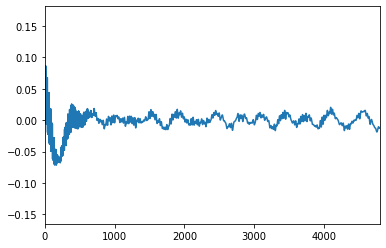

In [261]:
wavelet1 = pywt.cwt(MIT_signal,200,"mexh")
plt.plot(wavelet1[0][0])
plt.xlim(0,4800)

Casting complex values to real discards the imaginary part


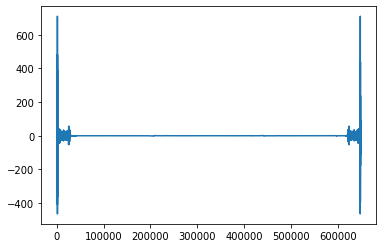

In [262]:
fourier1 = fft(wavelet1[0][0])
plt.plot(fourier1)

In [263]:
freq_cst = (1/(np.sqrt(2*np.pi)))

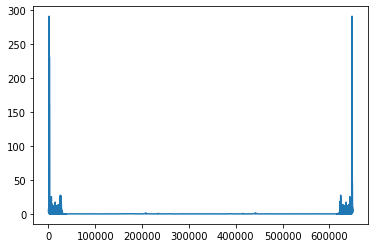

In [264]:
fourier1 = np.absolute(fourier1)
fourier1 = freq_cst*fourier1
plt.plot(fourier1)

(0, 10)

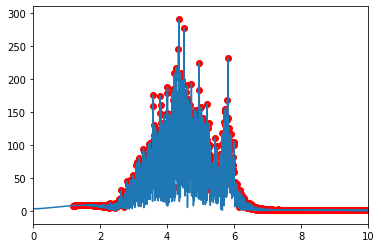

In [265]:
M = argrelextrema(fourier1,np.greater)[0]
plt.plot(time[0:len(fourier1)],fourier1)
plt.scatter(time[M],fourier1[M],color='red')
plt.xlim(0,10)

2400

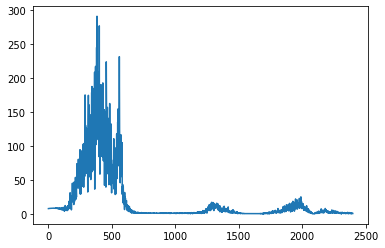

In [266]:
plt.plot(fourier1[M[0:2400]])
len(fourier1[M[0:2400]])

In [267]:
def SPEC2(signal):
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = signal[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    A3 = A3_calc(signal,God_of_War)
    
    return A3

In [268]:
SPEC2(fourier1[M[0:2400]])

0.0026169056289506716

In [269]:
def wavelet_one(signal):
    wavelet1 = pywt.cwt(signal,200,"mexh")
    fourier1 = fft(wavelet1[0][0])
    freq_cst = (1/(np.sqrt(2*np.pi)))
    fourier1 = np.absolute(fourier1)
    fourier1 = freq_cst*fourier1
    M = argrelextrema(fourier1,np.greater)[0]
    
    return SPEC2(fourier1[M[0:2400]])

In [270]:
wavelet_one(MIT_signal[0:2400])

0.0055815439758716895

## Wavelet 1:

In [ ]:
def Wave1_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(wavelet_one(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
Wave1_DF = Wave1_ext(ss)

## Wavelet 2:

Need to turn the SPEC algorithm into one big algorithm. This uses SPEC to check whether the signal is VF, if it is, then this second wavelet does not need to be considered. If it doesn't however, the following is performed:

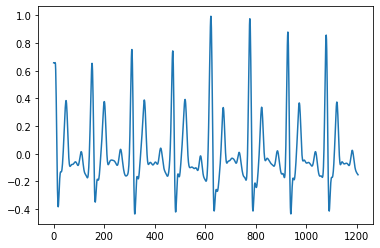

In [246]:
w = pywt.dwt(MIT_signal[0:2400],'db8','smooth')
plt.plot(w[0])

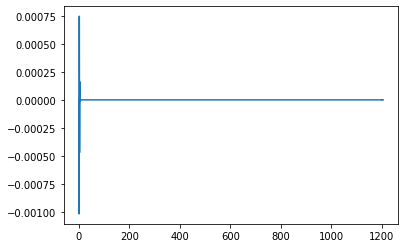

In [247]:
plt.plot(w[1])

In [248]:
qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
len(qrs_wave2)/3

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


5.666666666666667

In [ ]:
plt.plot()

In [249]:
def Wave_2(signal):
    w = pywt.dwt(MIT_signal[0:2400],'db8','smooth')
    qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
    return len(qrs_wave2)/3

In [250]:
Wave_2(MIT_signal[0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


5.666666666666667

## Wavelet 2:

In [ ]:
def Wave2_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(Wave_2(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

# Parameter 10: Li Algorithm

I used the continuous wavelet instead, as it allows for scaling:

In [251]:
def wavelet_finder(signal):
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    w1 = pywt.cwt(signal,2,'mexh')
    plt.plot(w1[0][0])
    
    w2 = pywt.cwt(signal,np.power(2,2),'mexh')
    plt.figure()
    plt.plot(w2[0][0])
    
    w3 = pywt.cwt(signal,np.power(2,3),'mexh')
    plt.figure()
    plt.plot(w3[0][0])
    
    w4 = pywt.cwt(signal,np.power(2,4),'mexh')
    plt.figure()
    plt.plot(w4[0][0])
    
    return w1,w2,w3,w4

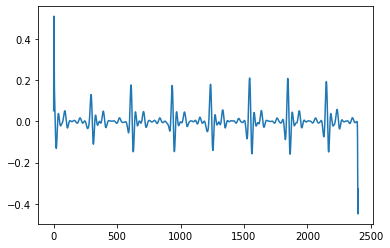

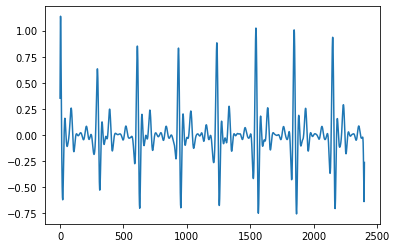

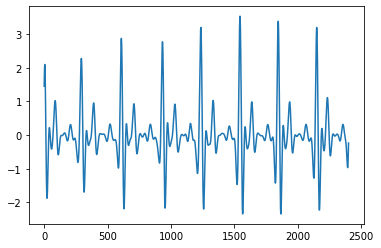

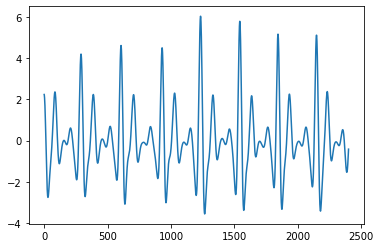

In [252]:
w1,w2,w3,w4 = wavelet_finder(MIT_signal[0:2400])

In [253]:
time1 = time[0:2400]
time2 = time[0:2400]
time3 = time[0:2400]
time4 = time[0:2400]

In [254]:
w1,time1 = signal_preprocessor(w1[0][0],time1,200,30)
w2,time2 = signal_preprocessor(w2[0][0],time2,200,30)
w3,time3 = signal_preprocessor(w3[0][0],time3,200,30)
w4,time4 = signal_preprocessor(w4[0][0],time4,200,30)

In [255]:
def QRS_number_search(w1,w2,w3,w4,fs):
    qrs_w1 = processing.xqrs_detect(sig=w1, fs=fs)
    qrs_w2 = processing.xqrs_detect(sig=w2, fs=fs)
    qrs_w3 = processing.xqrs_detect(sig=w3, fs=fs)
    qrs_w4 = processing.xqrs_detect(sig=w4, fs=fs)
    
    return qrs_w1,qrs_w2,qrs_w3,qrs_w4

In [256]:
qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


14.333333333333334

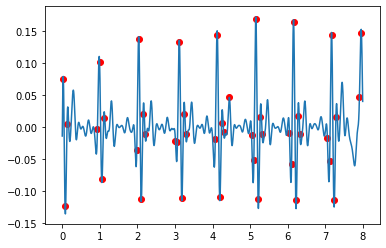

In [257]:
plt.plot(time1,w1)
plt.scatter(time1[qrs1],w1[qrs1],color="red")
len(qrs1)/3

0 or greater than 5 times the window length in seconds, so 40 in the 8 second interval case

# Parameter 11: Tompkins Algorithm

In [ ]:
sig = np.gradient(MIT_signal[0:2400],edge_order=1)
plt.plot(time[0:2400],sig)

In [ ]:
signal = np.power(sig,2)
plt.plot(time[0:2400],signal)

In [ ]:
time2 = time[0:2400]
time2.shape

In [ ]:
signal.shape

In [ ]:
sigmig,time3 = signal_preprocessor(signal,time2,200,30)
sigmig = np.array(sigmig)
plt.plot(time3,sigmig)

In [ ]:
qrs = processing.xqrs_detect(sig=sigmig, fs=41)
plt.plot(time3,sigmig)
plt.scatter(time3[qrs],sigmig[qrs],color="Red")
len(qrs)/3

# Parameter 12: Mean Absolute Value Algorithm

In [183]:
def mav(signal,I1,I2):
    s = 0
    sig = signal/np.amax(np.absolute(signal))
    for i in sig[I1:I2]:
        s+=np.absolute(i)
    return s/len(signal)

In [184]:
mav(ss[2][0][0:2400],0,300)

0.02644043557461253

In [185]:
np.arange(0,int(len(ss[2][0][0:2400])/300)-1,1)

array([0, 1, 2, 3, 4, 5, 6])

In [186]:
def mav_avg(signal,length):
    L = (length-1)
    ran = np.arange(0,int(len(signal)/300)-2,1)
    I1 = 0
    I2= 600
    mavi = []
    for i in ran:
        mavi.append(7*mav(signal,I1,I2))
        I1+=300
        I2+=300
    avg_mav = np.mean(mavi)
    return avg_mav

In [187]:
mav_avg(ss[100][22][0:2400],2)

0.28161079226184715

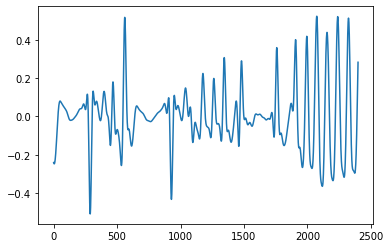

In [188]:
plt.plot(ss[100][22][0:2400])

Note that the threshold for VF-VT is 0.27

### Spectral Algorithm:

The only problem I have now is the calculation of the first spectral moment. I found some package that does it, but I'm not sure if it is the correct way. 

### Signal Comparison Algorithm:

How do I average the signals? The problem is that the QRS complexes... etc. are all at different indexes, which means that I can't average them. I triend using the starting point as the max before adding them, but that doesn't seem to work. Need something else.

# Fixes:

1. SPEC check which signal needs to be operated on and check the modulus 